In [ ]:
import sys
from pathlib import Path

import colorcet as cc
import numpy as np
import pandas as pd

# load and prepare data
import polars as pl
import seaborn as sns
import spatialdata as sd
from sainsc import LazyKDE
from tqdm import tqdm

import troutpy
from troutpy.pp import process_dataframe

/home/sergio/.local/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/sergio/.local/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/sergio/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


# Read data and perform analysis

In [2]:
sys.path.insert(0, "../../")  # this depends on the notebook depth and must be adapted per notebook
RESULTS_DIR = "/media/sergio/Meninges/troutpy/xenium_msbrain"
compressed_transcript_csv = Path(RESULTS_DIR, "sainsc", "trans.csv.gz")

In [3]:
xenium_path_cropped = "/media/sergio/Meninges/troutpy/xenium_msbrain/mousebrain_prime_crop_communication.zarr"
sdata = sd.read_zarr(xenium_path_cropped)

In [ ]:
# parameters
binsize_param = 3
celltype_key = "leiden"
background_filter = 0.4

,x,y,z,feature_name,cell_id,nucleus_distance,overlaps_nucleus,fov_name,is_gene,qv,codeword_category,codeword_index,transcript_id,segmentation_free_clusters,bin_id,overlaps_cell,extracellular
npartitions=1,,,,,,,,,,,,,,,,,
,float32,float32,float32,category[unknown],string,float32,uint8,string,bool,float32,string,int32,uint64,int64,int64,int64,bool
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
transcripts_all = sdata.points["transcripts"][
    ["feature_name", "x", "y", "codeword_category", "overlaps_nucleus", "transcript_id", "overlaps_cell"]
].compute()
transcripts_all = transcripts_all.reset_index(drop=True)
transcripts_all = transcripts_all.rename({"feature_name": "gene", "x": "x", "y": "y"})
transcripts_all = transcripts_all[transcripts_all["codeword_category"] == "predesigned_gene"]
transcripts_all = transcripts_all[transcripts_all["feature_name"].astype(str) != "nan"]
transcripts = transcripts_all[["feature_name", "x", "y", "codeword_category"]]
transcripts.columns = ["gene", "x", "y", "codeword_category"]
transcripts.to_csv(compressed_transcript_csv, compression="gzip")

In [ ]:
n_threads = 16
# Read xenium file, rename columns and filter blanks/controls
transcripts = pl.read_csv(
    compressed_transcript_csv,
    columns=["gene", "x", "y"],
    schema_overrides={"gene": pl.Categorical},
    n_threads=n_threads,
)  # .filter(~pl.col("gene").cast(pl.Utf8).str.contains("(BLANK|NegControl)"))

brain = LazyKDE.from_dataframe(transcripts, resolution=1000, binsize=binsize_param, n_threads=n_threads)

# Current status --reimplemented the rust function to compute dataframe from grid.
 The issue is that we need to see the most efficent way of retrieve counts while using Sainsc

In [ ]:
results, shape, transcript2bin_info = process_dataframe(transcripts, binsize=binsize_param, n_threads=n_threads)
# Assuming `transcript2bin_info` is a Polars DataFrame with 'bin_x' and 'bin_y' columns, we convert it to pandas df
transcript2bin_info = transcript2bin_info.to_pandas()
# This will create a new column `bin_x_y_id` as the concatenation of 'bin_x' and 'bin_y'
transcript2bin_info["bin_x_y_id"] = transcript2bin_info["bin_x"].astype(str) + "_" + transcript2bin_info["bin_y"].astype(str)

# the following lines we do to make sure that xy match in both datasets


xalls = []
for f in tqdm(transcripts_all["x"]):
    xalls.append(np.round(f, 4))
yalls = []
for f in tqdm(transcripts_all["y"]):
    yalls.append(np.round(f, 4))
###
transcripts_all["x"] = xalls
transcripts_all["y"] = yalls
transcripts_all["xy"] = transcripts_all["x"].astype(str) + "_" + transcripts_all["y"].astype(str)
transcript2bin_info["xy"] = transcript2bin_info["x"].astype(str) + "_" + transcript2bin_info["y"].astype(str)
id2overlap = dict(zip(transcripts_all["xy"], transcripts_all["overlaps_nucleus"], strict=False))
id2overlap_cell = dict(zip(transcripts_all["xy"], transcripts_all["overlaps_cell"], strict=False))
transcript2bin_info["overlaps_nucleus"] = transcript2bin_info["xy"].map(id2overlap)
transcript2bin_info["overlaps_cell"] = transcript2bin_info["xy"].map(id2overlap_cell)


xalls = []
for f in tqdm(transcripts_all["x"]):
    xalls.append(np.round(f, 4))
yalls = []
for f in tqdm(transcripts_all["y"]):
    yalls.append(np.round(f, 4))
###
transcripts_all["x"] = xalls
transcripts_all["y"] = yalls
transcripts_all["xy"] = transcripts_all["x"].astype(str) + "_" + transcripts_all["y"].astype(str)
transcript2bin_info["xy"] = transcript2bin_info["x"].astype(str) + "_" + transcript2bin_info["y"].astype(str)
id2overlap = dict(zip(transcripts_all["xy"], transcripts_all["overlaps_nucleus"], strict=False))
id2overlap_cell = dict(zip(transcripts_all["xy"], transcripts_all["overlaps_cell"], strict=False))
transcript2bin_info["overlaps_nucleus"] = transcript2bin_info["xy"].map(id2overlap)
transcript2bin_info["overlaps_cell"] = transcript2bin_info["xy"].map(id2overlap_cell)

Before we start it is good to get a brief overview of the two main Classes in sainsc.

- GridCounts: This class holds the data as a dictionary of sparse matrices of the same shape. You rarely will need to interact with it directly unless you want to, filter the genes or crop/mask the sample. It mostly behaves like a Python dictionary but is implemented in Rust. Therefore, iterating over the count matrices of each gene might be slow as the data needs to be transformed every time.
- LazyKDE: This is the class that you mostly will interact with. It contains a GridCounts instance in its counts attribute and otherwise exposes almost all methods necessary to perform the analysis.
We will use the transcripts.csv.gz (or transcripts.parquet) to load the locations of all identified transcripts. The control probes from the Xenium study will be automatically filtered out.

We can furthermore specify the size of the bins we will asign the transcripts into (by default this is set to 0.5 um) and the number of threads we want to use to process the data.

There are options to directly load data from common file formats/technologies such as Stereo-seq, Xenium, and Vizgen. If none of the options fit for your use case you can have a look at LazyKDE.from_dataframe or GridCounts.from_dataframe methods.

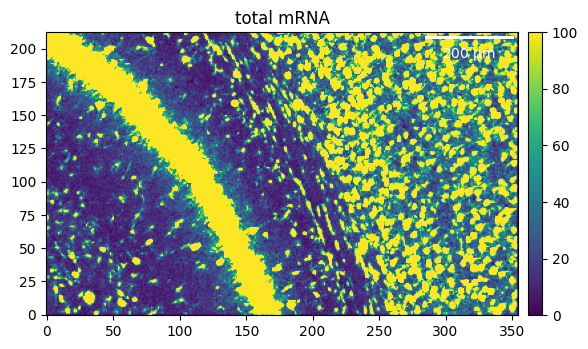

In [ ]:
brain.calculate_total_mRNA()
_ = brain.plot_genecount(im_kwargs={"vmax": 100})
_ = brain.plot_genecount_histogram()

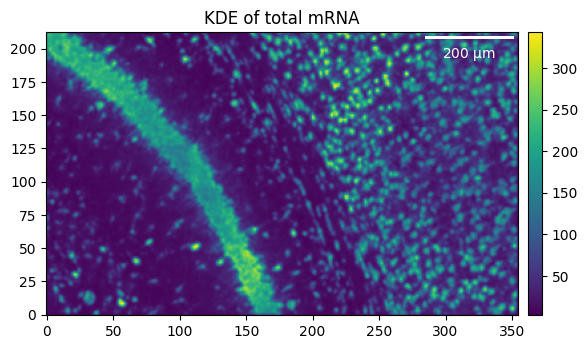

In [ ]:
brain.gaussian_kernel(2.5, unit="um")
brain.calculate_total_mRNA_KDE()
_ = brain.plot_KDE()

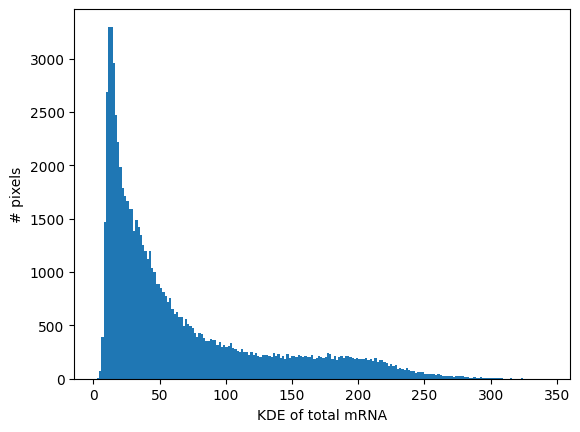

In [349]:
_ = brain.plot_KDE_histogram(bins=200)

In [ ]:
brain.filter_background(background_filter)

In [ ]:
adata = sdata["table"]
expr = adata.to_df()
expr["cell type"] = adata.obs[celltype_key]
signatures = expr.groupby("cell type").mean().transpose()

In [353]:
brain.assign_celltype(signatures, log=True)

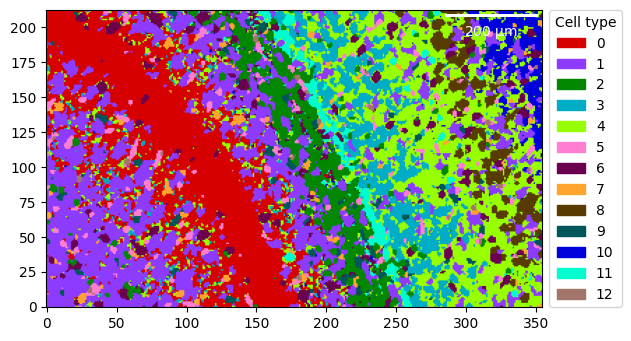

In [ ]:
cmap = dict(zip(brain.celltypes, sns.color_palette(cc.glasbey, n_colors=len(brain.celltypes)), strict=False))

_ = brain.plot_celltype_map(cmap=cmap)

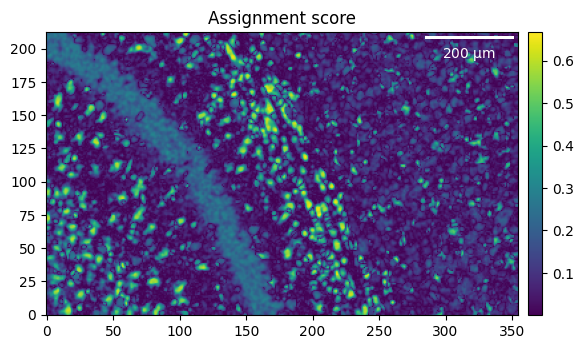

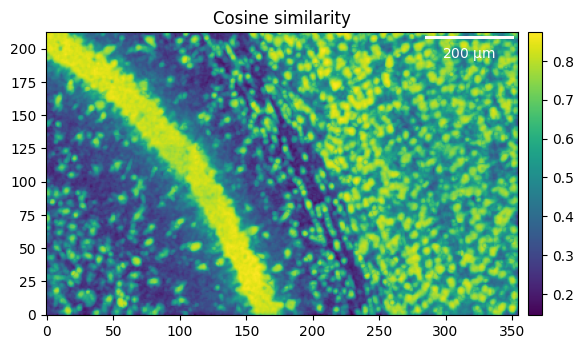

In [355]:
_ = brain.plot_assignment_score(remove_background=True)
_ = brain.plot_cosine_similarity()

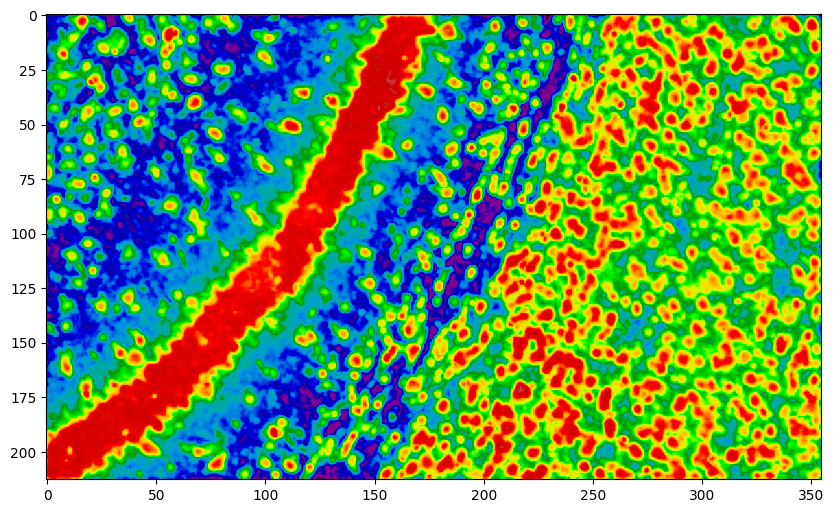

In [356]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(brain.cosine_similarity.transpose(), cmap="nipy_spectral", vmax=0.9)

In [ ]:
# Flattened features
celltype = brain.celltype_map.flatten()
assignment_score = brain.assignment_score.flatten()
cosine_similarity = brain.cosine_similarity.flatten()

# Calculate x, y coordinates based on the matrix shape
n_rows, n_cols = brain.celltype_map.shape  # Assuming brain.shape gives the shape of the matrix
x_coordinates, y_coordinates = np.meshgrid(np.arange(n_cols), np.arange(n_rows))

# Flatten the x and y coordinates to match the flattened data
x_coordinates = x_coordinates.flatten()
y_coordinates = y_coordinates.flatten()

# Create the DataFrame with the extracted features and coordinates
output_df = pd.DataFrame(
    {
        "bin_x": x_coordinates,
        "bin_y": y_coordinates,
        "cell type": celltype,
        "assignment_score": assignment_score,
        "cosine_similarity": cosine_similarity,
    }
)

# Map the cell type numbers to their actual names
num2ct = dict(zip(range(0, len(brain.celltypes)), brain.celltypes, strict=False))
output_df["cell type"] = output_df["cell type"].map(num2ct)

output_df["bin_x_y_id"] = output_df["bin_y"].astype(str) + "_" + output_df["bin_x"].astype(str)

# View the final DataFrame
output_df.head()

,bin_x,bin_y,cell type,assignment_score,cosine_similarity,bin_x_y_id
0,0,0,1,0.112851,0.245814,0_0
1,1,0,1,0.083987,0.249253,0_1
2,2,0,1,0.031190,0.233372,0_2
3,3,0,1,0.054114,0.234161,0_3
4,4,0,1,0.074469,0.256074,0_4


In [ ]:
bin2celltype = dict(zip(output_df["bin_x_y_id"], output_df["cell type"], strict=False))
bin2cosine_similarity = dict(zip(output_df["bin_x_y_id"], output_df["cosine_similarity"], strict=False))
bin2assignment_score = dict(zip(output_df["bin_x_y_id"], output_df["assignment_score"], strict=False))
transcript2bin_info["closest_cell_type"] = transcript2bin_info["bin_x_y_id"].map(bin2celltype)
transcript2bin_info["cosine_similarity"] = transcript2bin_info["bin_x_y_id"].map(bin2cosine_similarity)

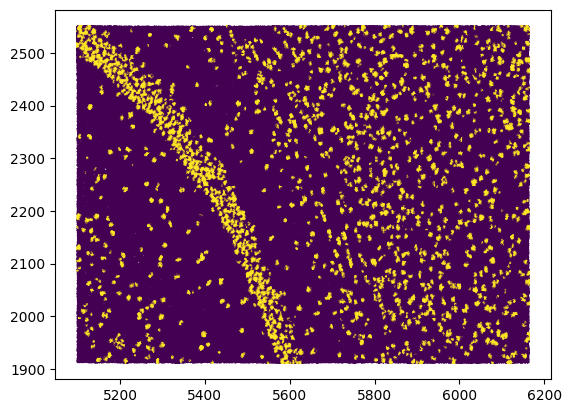

In [ ]:
plt.scatter(transcript2bin_info["x"], transcript2bin_info["y"], c=transcript2bin_info["overlaps_nucleus"], s=0.1)
plt.figure()
plt.scatter(transcript2bin_info["x"], transcript2bin_info["y"], c=transcript2bin_info["cosine_similarity"], s=0.1)

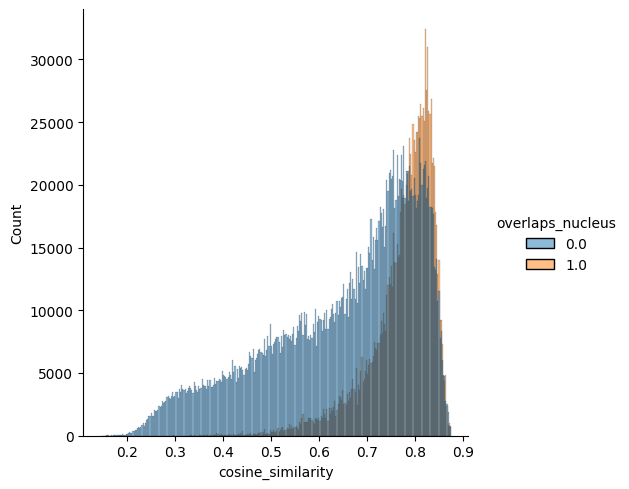

In [336]:
sns.displot(transcript2bin_info, x="cosine_similarity", hue="overlaps_nucleus")

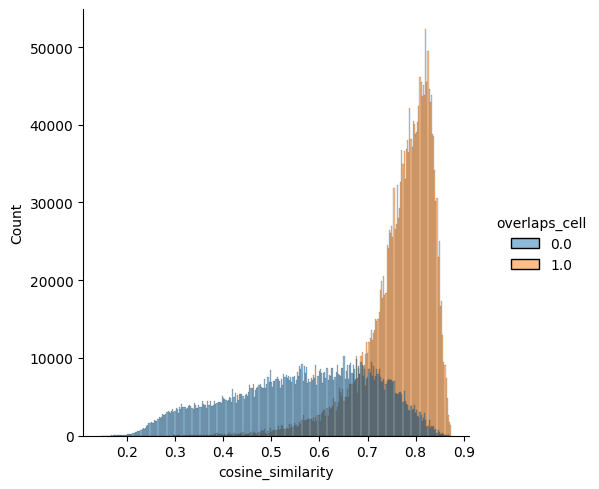

In [362]:
sns.displot(transcript2bin_info, x="cosine_similarity", hue="overlaps_cell")

In [389]:
# we should make the overlaps_cell column flexible, depending on the key specified. We also should make the percentile dependent on the given input
threshold = np.percentile(transcript2bin_info.loc[transcript2bin_info["overlaps_cell"] == 1, "cosine_similarity"], 10)
transcript2bin_info["match_cell_signature"] = transcript2bin_info["cosine_similarity"] > threshold
print(threshold)

0.6785410046577454


In [ ]:
xy2cosine_similarity = dict(zip(transcript2bin_info["xy"], transcript2bin_info["cosine_similarity"], strict=False))
xy2closest_cell_type = dict(zip(transcript2bin_info["xy"], transcript2bin_info["closest_cell_type"], strict=False))
transcripts_all["cosine_similarity"] = transcripts_all["xy"].map(xy2cosine_similarity)
transcripts_all["closest_cell_type"] = transcripts_all["xy"].map(xy2closest_cell_type)
id2cosine = dict(zip(transcripts_all.index, transcripts_all["cosine_similarity"], strict=False))
id2ct = dict(zip(transcripts_all.index, transcripts_all["closest_cell_type"], strict=False))
transi = sdata.points["transcripts"].compute()
transi["cosine_similarity"] = transi.index.map(id2cosine)
transi["closest_cell_type"] = transi.index.map(id2ct)
transi["match_cell_signature"] = transi["cosine_similarity"] > threshold

# now we reformat transcripts as points.

### plot cosine similarity by cell type

In [ ]:
for g, i in transcript2bin_info.groupby("closest_cell_type"):
    sns.displot(i, x="cosine_similarity", hue="overlaps_cell")
    plt.title(g)
    plt.show()

# Function implementation [TO BE ADDED TO PACKAGE]

In [4]:
troutpy.pp.segmentation_free_sainsc(sdata, binsize=3, celltype_key="leiden", background_filter=0.4, gaussian_kernel_key=2.5, n_threads=16)

In [5]:
troutpy.pp.define_extracellular(sdata, layer="transcripts", method="sainsc", unassigned_tag="UNASSIGNED", copy=False, percentile_threshold=2)

Cosine similarity threshold for extracellular definition: 0.5665629506111145


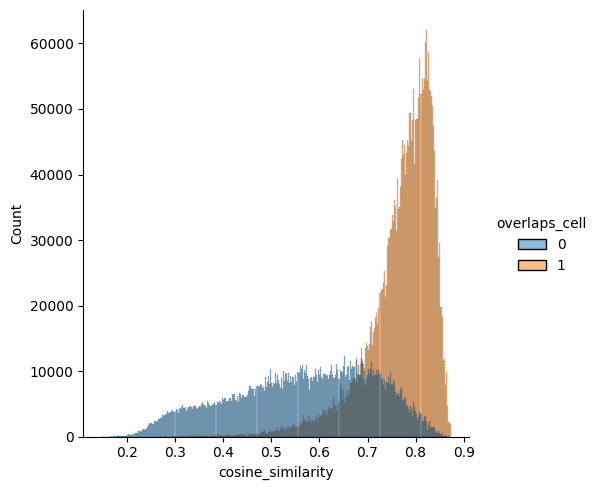

In [ ]:
transcript = sdata["transcripts"].compute()
sns.displot(transcript, x="cosine_similarity", hue="overlaps_cell")

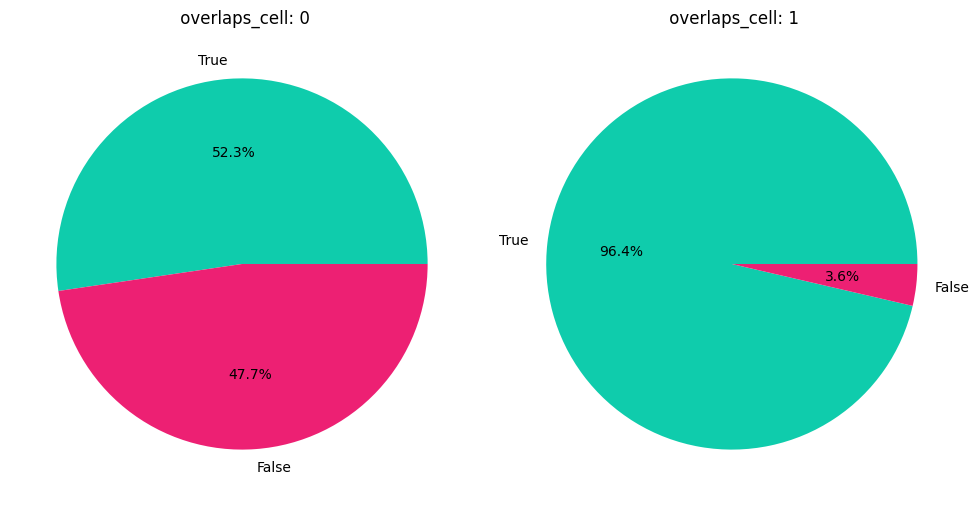

In [8]:
troutpy.pl.pie(sdata, groupby="match_cell_signature", group_key="overlaps_cell")

<Figure size 500x500 with 0 Axes>

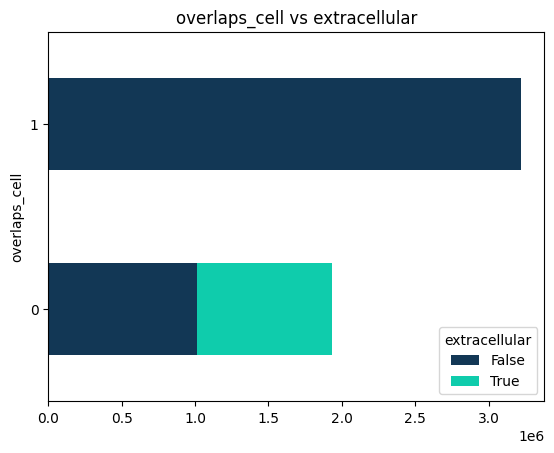

In [14]:
troutpy.pl.crosstab(sdata, yvar="extracellular", xvar="overlaps_cell", normalize=False, cmap="troutpy", kind="barh", stacked=True)

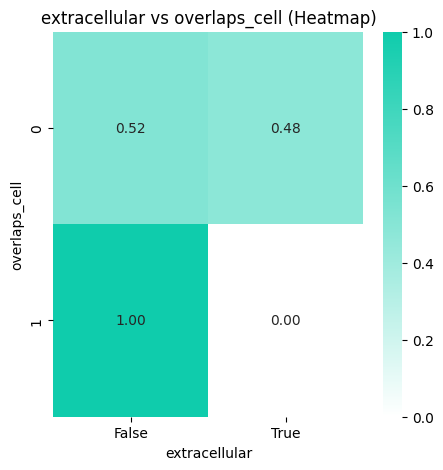

In [12]:
troutpy.pl.crosstab(sdata, xvar="extracellular", yvar="overlaps_cell", normalize=True, cmap="Aquas", kind="heatmap", stacked=True)

In [ ]:
fraction = 0.1  # 10% of transcripts
subsampled_transcripts = transcript.sample(frac=fraction, random_state=42)
subsampled_transcripts.to_csv("/media/sergio/Meninges/troutpy/trans.csv")

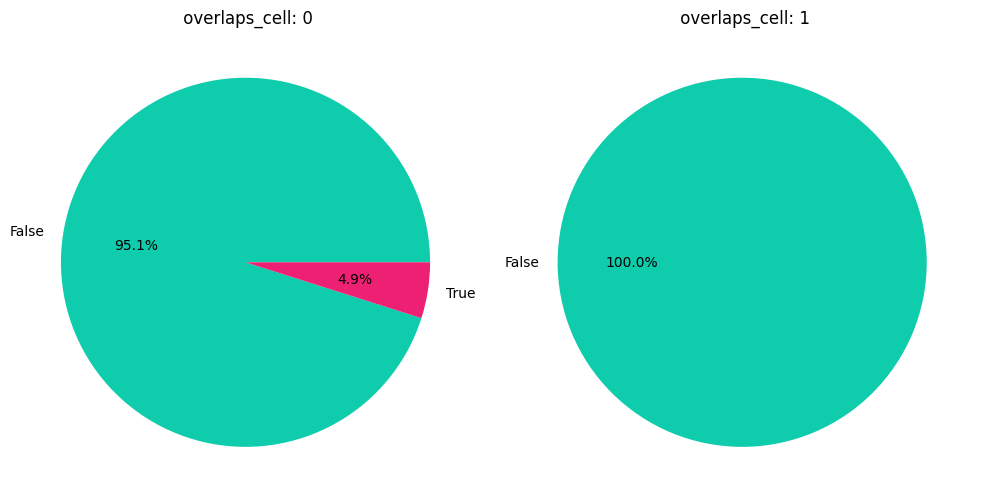

In [8]:
troutpy.pl.pie(sdata, groupby="extracellular", group_key="overlaps_cell")